# Wine Case Analysis: *Wine Spectator*'s Top 100 Wines, 1988-2020
List available online on *Wine Spectator*'s [Top 100 Lists web site](https://top100.winespectator.com/lists/).

## File Setup

In [826]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import bar_chart_race as bcr
import seaborn as sns

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other packages
from scipy import stats
from sklearn import linear_model

# import geo packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

# import Geopy packages
import geopy
from geopy.geocoders import Nominatim

In [827]:
# initialize vizualization set
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
sns.mpl.rc("figure", figsize=(10, 6))

# Jupyter Notebook
%matplotlib inline

## Dataframe Exploration

In [828]:
# Note: save CSV files in UTF-8 format to preserve special characters.
df_Wine = pd.read_csv('./Wine_Hier00.csv')
df_GeoCache = pd.read_csv('./GeoCache.csv')
df_Flag = pd.read_csv('./emoji_list.csv')

In [829]:
df_Wine.shape

(3301, 25)

In [830]:
df_Wine.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [831]:
# CSV of wines is retaining a blank row at the end of the dataset. Remove the last row to prevent data type errors.

# number of rows to drop
n = 1

df_Wine.drop(df_Wine.tail(n).index, inplace = True)

In [832]:
# Review_Year
# Convert Review_Year from float to int
df_Wine['Review_Year'] = df_Wine['Review_Year'].astype(int)

In [833]:
df_GeoCache.shape

(1224, 8)

In [834]:
df_Flag.shape

(19, 3)

In [835]:
df_Wine.sample(10)

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_from,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude
1795,2003,96,2000,93.0,45,Ojai,Syrah California Roll Ranch Vineyard,Red,Shiraz | Syrah,NaN,...,2003.0,2010.0,"Simply delicious, overflowing with flavor. Ink...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
155,2019,56,2016,96.0,99,Quinta do Vale Meão,Douro,Red,Blend,"Touriga Nacional, Touriga Franca, Tinta Barroc...",...,2021.0,2030.0,"Well-crafted, balancing power and finesse, thi...",Hierarchy_00,Portugal,Portugal,"(40.0332629, -7.8896263, 0.0)",40.033263,-7.889626,0.0
2925,1991,26,1989,92.0,12,Hogue,Merlot Washington,Red,Merlot,NaN,...,1991.0,NaN,"An exciting wine at a good price. Crisp, brigh...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
3271,1988,72,1986,94.0,50,Chartron & Trébuchet,Puligny-Montrachet Clos de la Pucelle Domaine ...,White,Chardonnay,NaN,...,NaN,NaN,"Hums with intensity, yet it sits lightly on th...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
2753,1993,54,1992,92.0,15,Bonny Doon,Muscat Canelli Monterey Vin de Glacière,White,Muscat,NaN,...,1993.0,NaN,"Brilliantly spicy, fruity and generous, showin...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
323,2017,24,2014,94.0,50,Justin,Justification Paso Robles,Red,Blend,Cabernet Franc and Merlot,...,2017.0,2035.0,"Smooth-textured, graceful and refined, with a ...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
2357,1997,58,1995,92.0,15,Charles Krug,Merlot Napa Valley Peter Mondavi Family,Red,Merlot,NaN,...,NaN,NaN,"Delivers plenty of detailed flavors, with pret...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
399,2017,100,2015,95.0,67,Sadie Family,'T Voetpad Swartland,White,Blend,"Chenin Blanc, Sémillon, Palomino and Muscat",...,2017.0,2024.0,"Dried lemon peel, fennel seed and honeysuckle ...",Hierarchy_00,South Africa,South Africa,"(-28.8166236, 24.991639, 0.0)",-28.816624,24.991639,0.0
3107,1989,8,1986,93.0,95,Château Mouton-Rothschild,Pauillac,Red,Blend,Bordeaux Blend Red,...,1999.0,2010.0,Defines Mouton's greatness with incredibly ric...,Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
2070,2000,71,1997,91.0,22,Gallo of Sonoma,Chardonnay Russian River Valley Laguna Ranch V...,White,Chardonnay,NaN,...,2000.0,2006.0,"Restrained on the nose, this tightly wound Cha...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0


## Vintage Wines where Cases Made was Non-Zero

In [836]:
# replace 'NaN' results in chart with 0 to facilitate analysis
df_Wine.fillna(value = 0, inplace = True)

In [837]:
# drop the non-numeric price row from the dataset
df_Wine = df_Wine[df_Wine.Price != '$49 / 500ml']

In [838]:
# Convert data type of price to numeric
df_Wine['Price'].astype(float)

0       139.0
1        85.0
2        90.0
3       135.0
4        90.0
5        90.0
6        53.0
7        99.0
8        95.0
9       175.0
10       40.0
11       40.0
12       45.0
13       52.0
14      110.0
15       60.0
16       23.0
17       35.0
18       35.0
19       28.0
20       12.0
21       40.0
22       17.0
23       71.0
24       18.0
25       24.0
26       70.0
27       22.0
28       40.0
29       15.0
        ...  
3270     47.0
3271     50.0
3272     41.0
3273      9.0
3274      8.0
3275     22.0
3276     93.0
3277      7.0
3278     12.0
3279     10.0
3280      9.0
3281     10.0
3282     14.0
3283     11.0
3284     12.0
3285     14.0
3286     14.0
3287      6.0
3288      7.0
3289      7.0
3290      7.0
3291      8.0
3292     11.0
3293     17.0
3294     18.0
3295     16.0
3296     30.0
3297      9.0
3298     15.0
3299    150.0
Name: Price, Length: 3299, dtype: float64

In [839]:
# Remove Non-Vintage (NV) wines from df_Wine
# Include only wines with a Cases_Made value

df_Wine_V = df_Wine[
    (df_Wine.Vintage != 'NV') &
    (df_Wine.Cases_Made != 0)
]

df_Wine_V.shape

(2664, 25)

In [840]:
# Average Cases Made by Wine Style - All Years
df_CM_All = pd.DataFrame({'Avg_Cases_Made' : df_Wine_V.groupby(['Wine_Style'])['Cases_Made'].mean()}).reset_index()
df_CM_All

,Wine_Style,Avg_Cases_Made
0,Dessert & Fortified,6936.120690
1,Red,9299.570304
2,Rosé | Rosado,12566.571429
3,Sparkling,6874.969697
4,White,12536.057576


In [841]:
# Average Cases Made by Wine Style - By Vintage Year
df_CM_ByYear = pd.DataFrame({'Avg_Cases_Made' : df_Wine_V.groupby(['Vintage', 'Wine_Style'])['Cases_Made'].mean()}).reset_index()
df_CM_ByYear.sample(10)

,Vintage,Wine_Style,Avg_Cases_Made
2,1983,Red,2224.000000
42,1996,Red,12322.100000
60,2001,White,10139.035714
84,2009,Red,6201.500000
47,1997,Sparkling,775.000000
89,2010,White,7923.800000
40,1995,White,9838.216216
59,2001,Red,12151.643836
123,2019,Red,88540.000000
91,2011,Red,14160.439024


### Visualization

In [842]:
# set palette and dimensions
palette = sns.color_palette('colorblind')

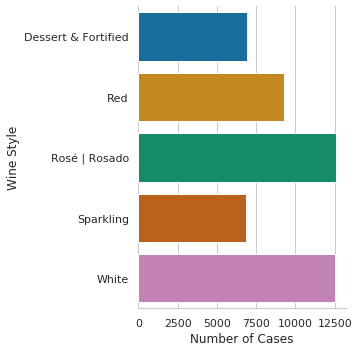

<Figure size 432x288 with 0 Axes>

In [843]:
# bar plot of summary data

g = sns.catplot(
    data = df_CM_All,
    kind = 'bar',
    y = 'Wine_Style',
    x = 'Avg_Cases_Made'
)

fig = plt.figure()

g.despine(left = True)
g.set_axis_labels('Number of Cases', 'Wine Style')

plt.suptitle('Average Cases Made by Wine Style\nReview Years 1988-2020', y = 1.1)
plt.savefig('./images/catplot_avgcases_by_winestyle.png')

In [844]:
# define a function to plot cases made by year by wine style

def cmby(wine_style):
    df = df_CM_ByYear[
        (df_CM_ByYear['Wine_Style'] == wine_style )
    ]
    
    # set palette and dimensions
    palette = sns.color_palette('colorblind')
    
    dim = (8, 10)
    fig, ax = plt.subplots(figsize = dim)
    
    g = sns.barplot(
        data = df,
        orient = 'h',
        y = 'Vintage',
        x = 'Avg_Cases_Made'
    )
    
    plt.suptitle(wine_style + '\nAverage Number of Cases Made by Vintage Year\nReview Years 1988-2020', y = 1)
    
    plt.savefig('./images/casesmade_by_vintage_year' + wine_style + '.png')

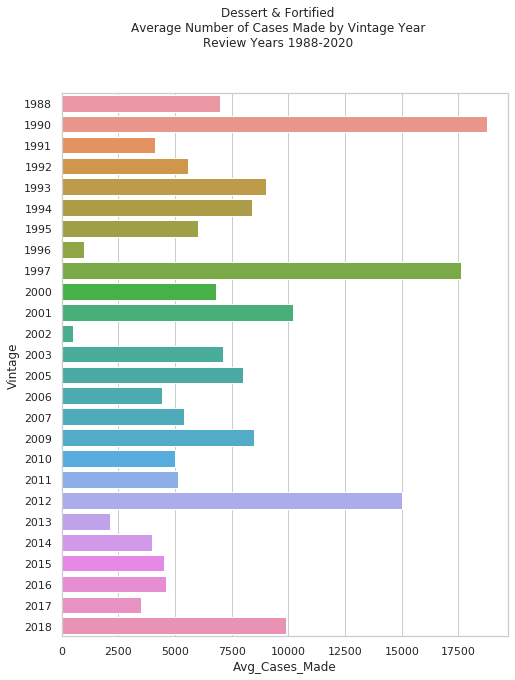

In [845]:
cmby('Dessert & Fortified')

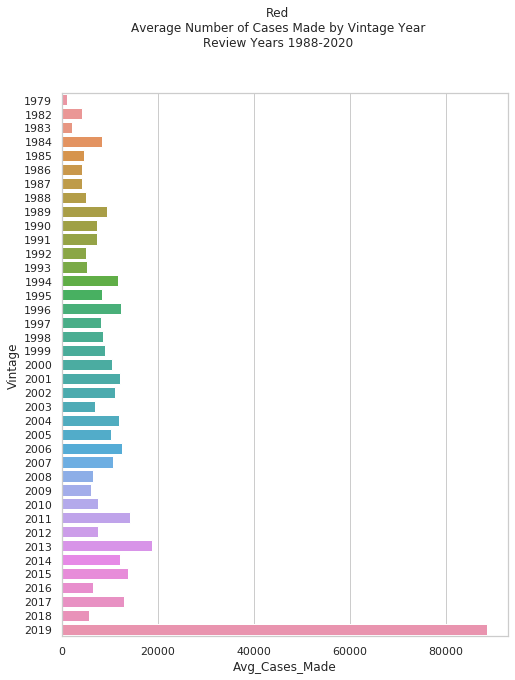

In [846]:
cmby('Red')

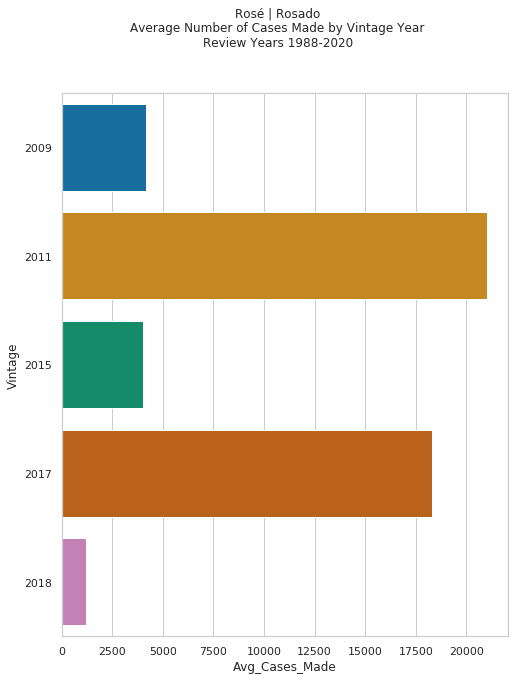

In [847]:
cmby('Rosé | Rosado')

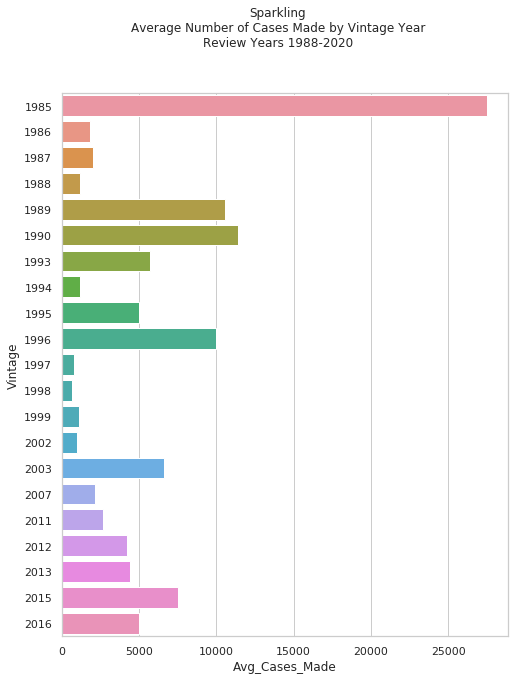

In [848]:
cmby('Sparkling')

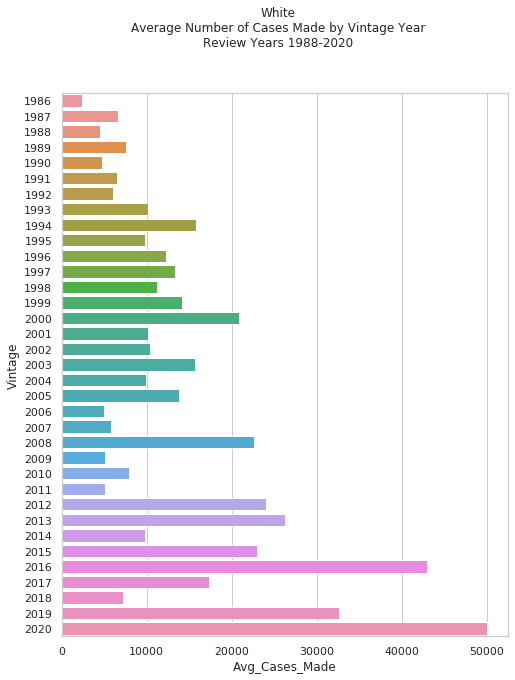

In [849]:
cmby('White')

In [850]:
# Create a dataset that allows for next-level analysis

df_CMBYBC = pd.DataFrame({'Avg_Cases_Made' : df_Wine_V.groupby(['Vintage', 'Wine_Style', 'Address'])['Cases_Made'].mean()})
df_CMBYBC = df_CMBYBC.reset_index()
df_CMBYBC.head()

,Vintage,Wine_Style,Address,Avg_Cases_Made
0,1979,Red,Spain,1000.0
1,1982,Red,Australia,5000.0
2,1982,Red,Spain,3500.0
3,1983,Red,Portugal,2224.0
4,1984,Red,USA,8465.0


In [851]:
# Write functions to explore specific vintage years by wine style and by country

def cmbybc(wine_style, vintage):
    df = df_CMBYBC[
        (df_CMBYBC['Wine_Style'] == wine_style ) &
        (df_CMBYBC['Vintage'] == vintage)
    ]
    
    # set palette and dimensions
    palette = sns.color_palette('colorblind')
    
    #dim = (8, 10)
    #fig, ax = plt.subplots(figsize = dim)
    
    g = sns.barplot(
        data = df,
        orient = 'h',
        y = 'Address',
        x = 'Avg_Cases_Made'
    )
    
    plt.suptitle(wine_style + '\nAverage Number of Cases Made by Country\n' + vintage + ' Vintage', y = 1.1)
    
    plt.savefig('./images/casesmade_by_country' + vintage + '_vintage.png')
    
def cmbybc_table(wine_style, vintage):
    df = df_Wine_V[
        (df_Wine_V['Wine_Style'] == wine_style ) &
        (df_Wine_V['Vintage'] == vintage)
    ]
    
    print(df[['Review_Year', 'Rank', 'Vintage', 'Score', 'Price', 'Winemaker', 'Wine', 'Wine_Style', 'Grape_Blend', 'Cases_Made', 'Cases_Imported', 'Geography', 'Address']])

In [852]:
# Explore Red wines, 2019
cmbybc_table('Red', '2019')

    Review_Year Rank Vintage  Score Price         Winemaker  \
42         2020   43    2019   90.0    13  Domaine Bousquet   

                 Wine Wine_Style Grape_Blend  Cases_Made  Cases_Imported  \
42  Malbec Tupungato         Red     Malbec      88540.0         27793.0   

    Geography    Address  
42  Tupungato  Argentina  


In [853]:
# Explore Sparkling Wines, 1985
cmbybc_table('Sparkling', '1985')

      Review_Year Rank Vintage  Score Price  Winemaker  \
3016         1990   17    1985   96.0    45  Bollinger   
3034         1990   35    1985   93.0    37     Lanson   

                             Wine Wine_Style Grape_Blend  Cases_Made  \
3016  Brut Champagne Grande Année  Sparkling   Champagne     15000.0   
3034    Brut Champagne Gold Label  Sparkling   Champagne     40000.0   

      Cases_Imported  Geography Address  
3016             0.0  Champagne  France  
3034             0.0  Champagne  France  


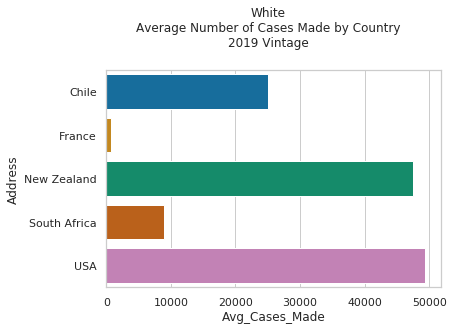

In [854]:
# Explore White Wines, 2019
cmbybc('White', '2019')

In [855]:
# Explore White Wines, 2019
cmbybc_table('White', '2019')

    Review_Year Rank Vintage  Score Price       Winemaker  \
20         2020   21    2019   92.0    12       Joel Gott   
49         2020   50    2019   90.0    14      Los Vascos   
58         2020   59    2019   90.0    16  Southern Right   
65         2020   66    2019   90.0    20          Invivo   
72         2020   73    2019   90.0    20      Spy Valley   
83         2020   84    2019   94.0    35           Delas   
93         2020   94    2019   90.0    15   Klinker Brick   

                                                 Wine Wine_Style  \
20                        Sauvignon Blanc California       White   
49                 Sauvignon Blanc Casablanca Valley       White   
58                        Sauvignon Blanc Walker Bay       White   
65  Sauvignon Blanc Marlborough X, Sarah Jessica P...      White   
72                       Sauvignon Blanc Marlborough       White   
83                     St.-Joseph White Les Challeys       White   
93                               Gr

In [856]:
# Explore White Wines, 2020
cmbybc_table('White', '2020')

    Review_Year Rank Vintage  Score Price    Winemaker  \
22         2020   23    2020   92.0    17  Allan Scott   

                            Wine Wine_Style      Grape_Blend  Cases_Made  \
22  Sauvignon Blanc Marlborough       White  Sauvignon Blanc     50000.0   

    Cases_Imported    Geography      Address  
22         16000.0  Marlborough  New Zealand  


## Vintage Wines where Cases Made and Cases Imported were Non-Zero

In [857]:
# Remove Non-Vintage (NV) wines from df_Wine
# Include only wines with a Cases_Made value and a Cases_Imported Value

df_Wine_VC = df_Wine[
    (df_Wine.Vintage != 'NV') &
    (df_Wine.Cases_Made != 0) &
    (df_Wine.Cases_Imported != 0)
]

df_Wine_VC.shape

(92, 25)

In [858]:
# Calculate Cases Imported as percentage of Cases Made

df_Wine_VC['Case_Ratio'] = df_Wine_VC['Cases_Imported'] / df_Wine_VC['Cases_Made']

/home/elizabethwotawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [859]:
df_Wine_VC.head()

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude,Case_Ratio
0,2020,1,2010,96.0,139,Bodegas Marqués de Murrieta,Rioja Castillo Ygay Gran Reserva Especial,Red,Blend,Tempranillo and Mazuelo.,...,2030.0,"Maturing well, this round red is a lovely exam...",Hierarchy_00,Spain,España,"(39.3260685, -4.8379791, 0.0)",39.326068,-4.837979,0.0,0.090667
2,2020,3,2015,97.0,90,San Filippo,Brunello di Montalcino Le Lucére,Red,Brunello di Montalcino,0,...,2043.0,"Effusive aromas of black currant, blueberry, v...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0,0.500000
4,2020,5,2016,96.0,90,Domaine de la Vieille Julienne,Châteauneuf-du-Pape Les Trois Sources,Red,Châteauneuf-du-Pape,0,...,2040.0,"A lush, ripe style, with açaí berry, blueberry...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0,0.250000
6,2020,7,2016,95.0,53,Massolino,Barolo,Red,Blend,Nebbiolo,...,2045.0,"A stream of pure, juicy cherry fruit is at the...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0,0.362069
10,2020,11,2016,97.0,40,Castello di Volpaia,Chianti Classico Riserva,Red,Chianti,0,...,2040.0,"Enticing aromas of black cherry, black currant...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0,0.550000


In [860]:
# Stack case information - Cases Made by Wine Style

df_CMWS = pd.DataFrame({'Avg_Cases' : df_Wine_V.groupby(['Vintage', 'Wine_Style'])['Cases_Made'].mean()})
df_CMWS = df_CMWS.reset_index()
df_CMWS['Case_Desc'] = 'Cases Made'
df_CMWS.head()

,Vintage,Wine_Style,Avg_Cases,Case_Desc
0,1979,Red,1000.000000,Cases Made
1,1982,Red,4250.000000,Cases Made
2,1983,Red,2224.000000,Cases Made
3,1984,Red,8465.000000,Cases Made
4,1985,Red,4617.896552,Cases Made


In [861]:
# Stack case information - Cases Imported by Wine Style

df_CIWS = pd.DataFrame({'Avg_Cases' : df_Wine_V.groupby(['Vintage', 'Wine_Style'])['Cases_Imported'].mean()})
df_CIWS = df_CIWS.reset_index()
df_CIWS['Case_Desc'] = 'Cases Imported'
df_CIWS.head()

,Vintage,Wine_Style,Avg_Cases,Case_Desc
0,1979,Red,0.0,Cases Imported
1,1982,Red,0.0,Cases Imported
2,1983,Red,0.0,Cases Imported
3,1984,Red,0.0,Cases Imported
4,1985,Red,0.0,Cases Imported


In [862]:
# Concatenate Cases Made, Cases Imported data frames by Wine Style

frames = [df_CMWS, df_CIWS]
df_Cases_WS = pd.concat(frames)
df_Cases_WS.head()

,Vintage,Wine_Style,Avg_Cases,Case_Desc
0,1979,Red,1000.000000,Cases Made
1,1982,Red,4250.000000,Cases Made
2,1983,Red,2224.000000,Cases Made
3,1984,Red,8465.000000,Cases Made
4,1985,Red,4617.896552,Cases Made


In [863]:
# Stack case information - Cases Made by Address

df_CMA = pd.DataFrame({'Avg_Cases' : df_Wine_VC.groupby(['Vintage', 'Address'])['Cases_Made'].mean()})
df_CMA = df_CMA.reset_index()
df_CMA['Case_Desc'] = 'Cases Made'
df_CMA.head()

,Vintage,Address,Avg_Cases,Case_Desc
0,2010,Spain,7500.0,Cases Made
1,2013,Italy,15000.0,Cases Made
2,2013,Spain,26500.0,Cases Made
3,2015,Chile,4500.0,Cases Made
4,2015,France,29166.5,Cases Made


In [864]:
# Stack case information - Cases Imported by Address

df_CIA = pd.DataFrame({'Avg_Cases' : df_Wine_VC.groupby(['Vintage', 'Address'])['Cases_Imported'].mean()})
df_CIA = df_CIA.reset_index()
df_CIA['Case_Desc'] = 'Cases Imported'
df_CIA.head()

,Vintage,Address,Avg_Cases,Case_Desc
0,2010,Spain,680.0,Cases Imported
1,2013,Italy,3000.0,Cases Imported
2,2013,Spain,15900.0,Cases Imported
3,2015,Chile,500.0,Cases Imported
4,2015,France,5350.0,Cases Imported


In [865]:
# Concatenate Cases Made, Cases Imported data frames by Address

frames = [df_CMA, df_CIA]
df_Cases_A = pd.concat(frames)
df_Cases_A.head()

,Vintage,Address,Avg_Cases,Case_Desc
0,2010,Spain,7500.0,Cases Made
1,2013,Italy,15000.0,Cases Made
2,2013,Spain,26500.0,Cases Made
3,2015,Chile,4500.0,Cases Made
4,2015,France,29166.5,Cases Made


In [866]:
# Write functions to explore specific vintage years by wine style and by country

def gpbar(style_or_address, spec_style_or_address):
    
    if style_or_address == 'style':
        df = df_Cases_WS[(df_Cases_WS.Wine_Style == spec_style_or_address)]
        header = 'Wine Style: ' + spec_style_or_address
    elif style or address == 'address':
        df = df_Cases_A[(df_Cases_A.Address == spec_style_or_address)]
        header = 'Geography: ' +  spec_style_or_address
    else:
        print('select style or address')
        
    dim = (8, 10)
    fig, ax = plt.subplots(figsize = dim)
    
    # set palette and dimensions
    palette = sns.color_palette('colorblind')
    
    g = sns.barplot(
        data = df,
        orient = 'h',
        y = 'Vintage',
        x = 'Avg_Cases',
        hue = 'Case_Desc',
    )

    plt.suptitle(header + '\nAverage Number of Cases Made and Imported by Vintage\nReview Years 1988-2020', y = 1)
    
    fig.savefig('./images/casesmade_casesimported_' + style_or_address + '_' + spec_style_or_address + '.png')

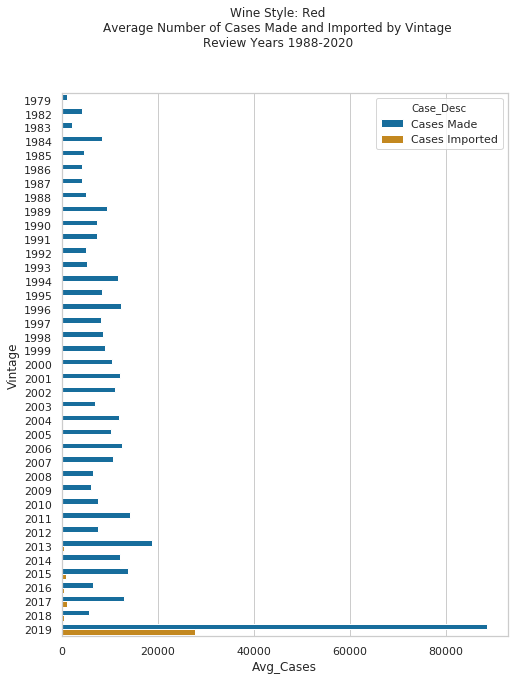

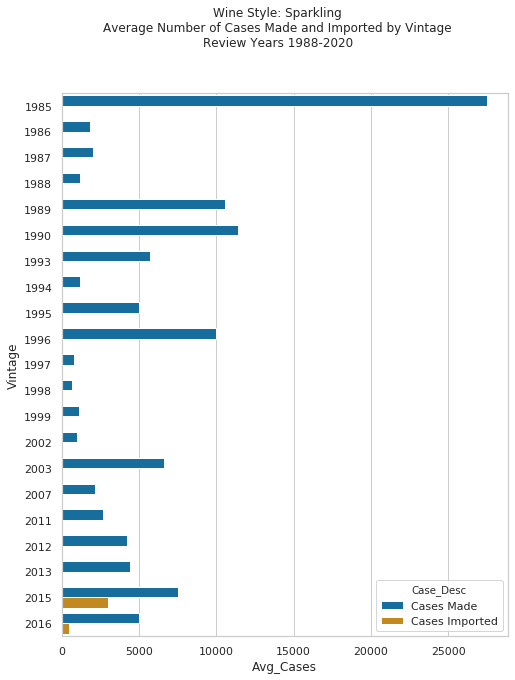

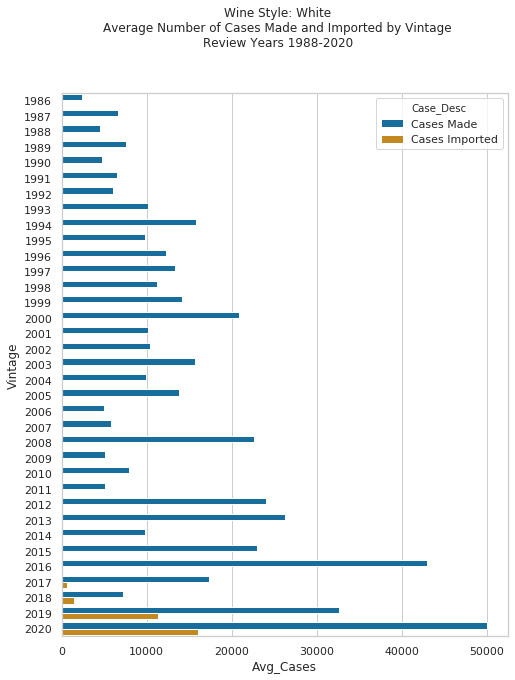

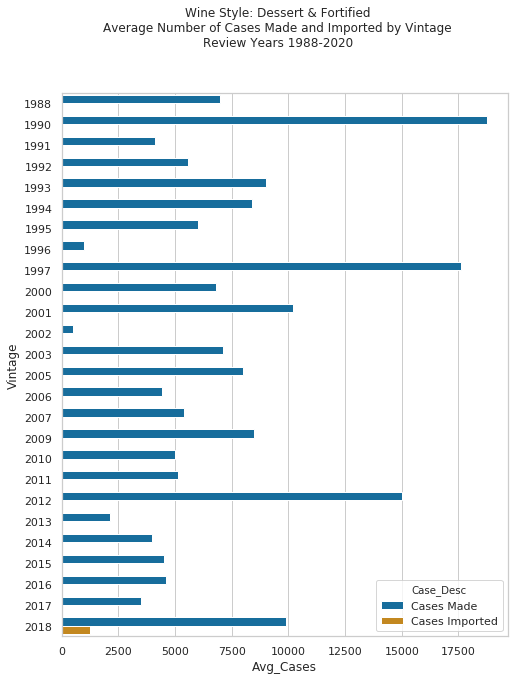

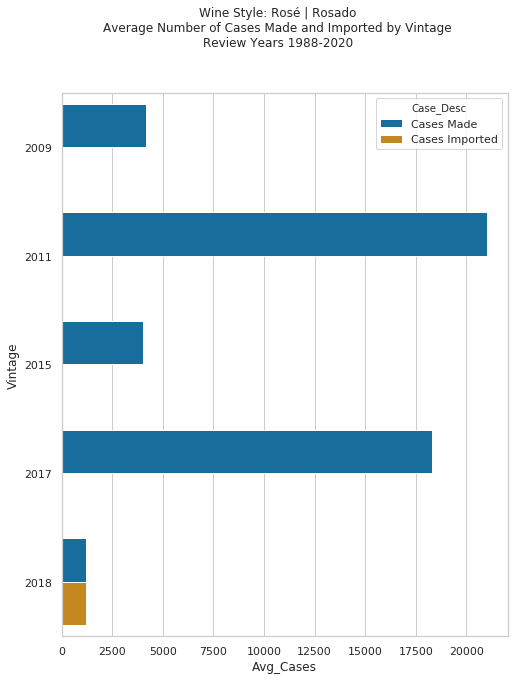

In [867]:
styles = df_Cases_WS.Wine_Style.unique()
styles

for style in styles:
    gpbar('style', style)

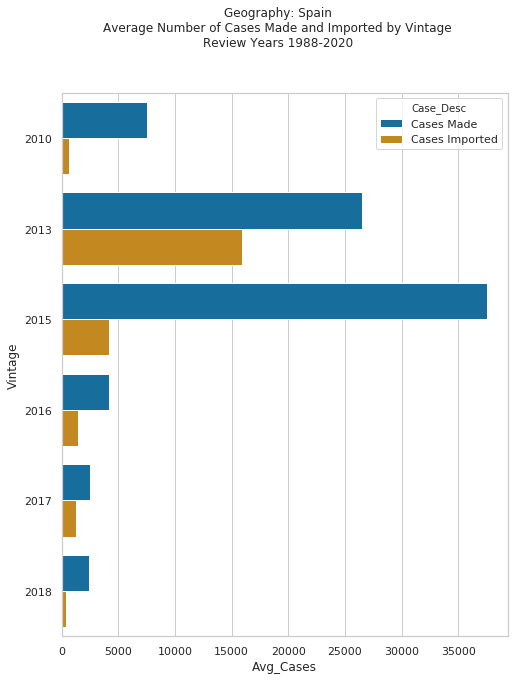

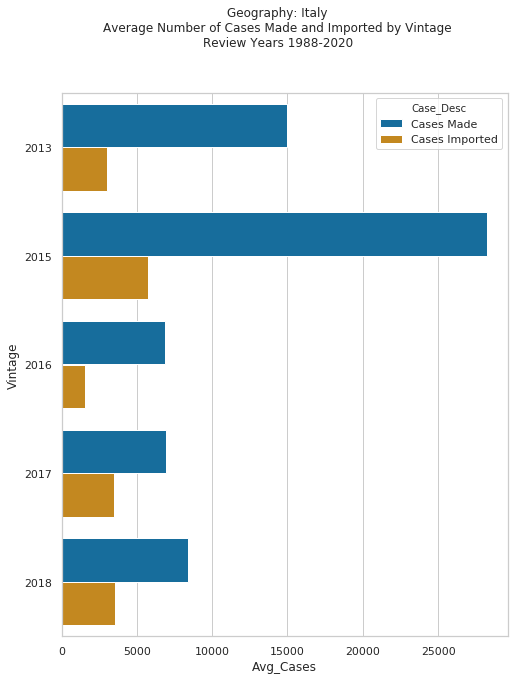

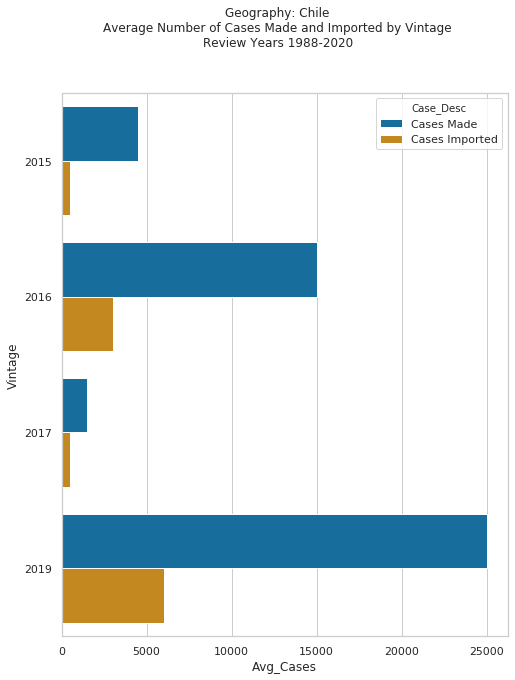

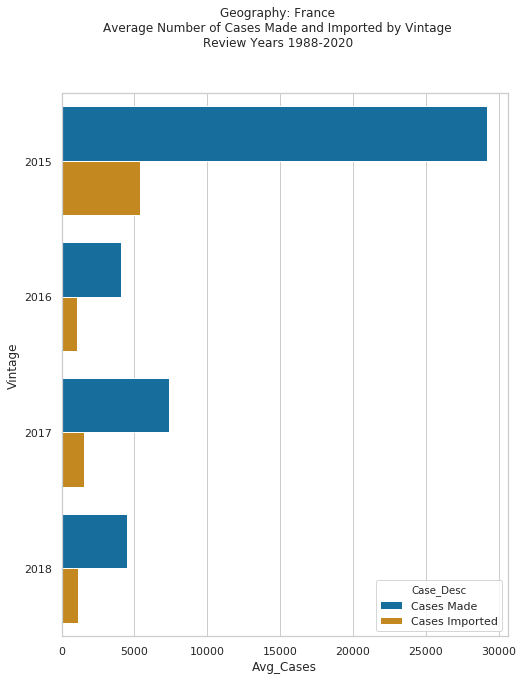

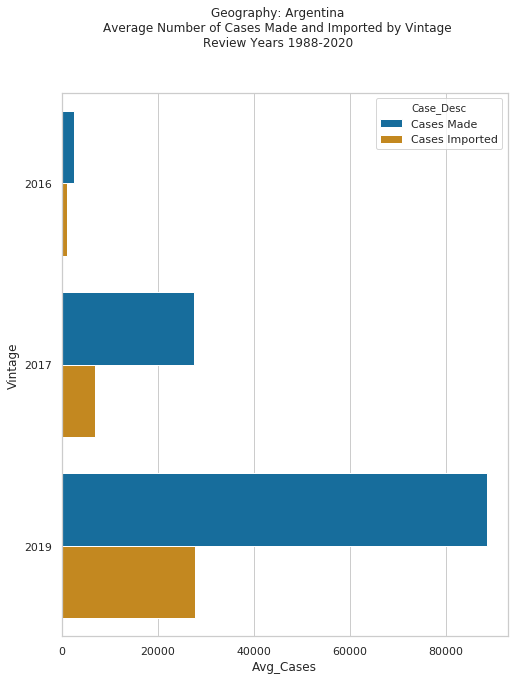

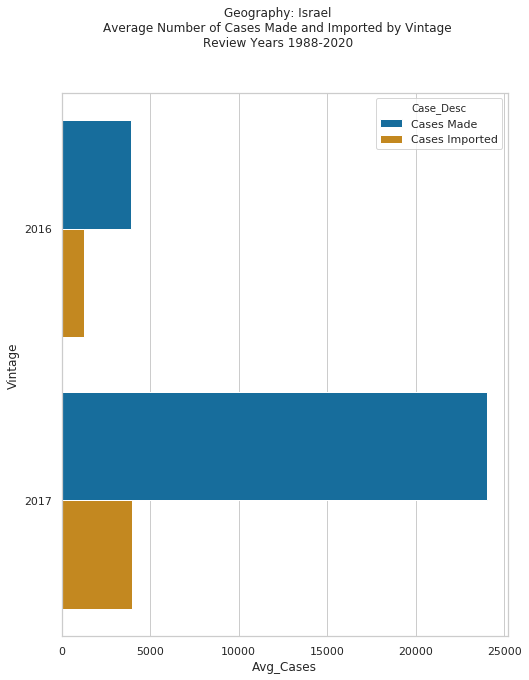

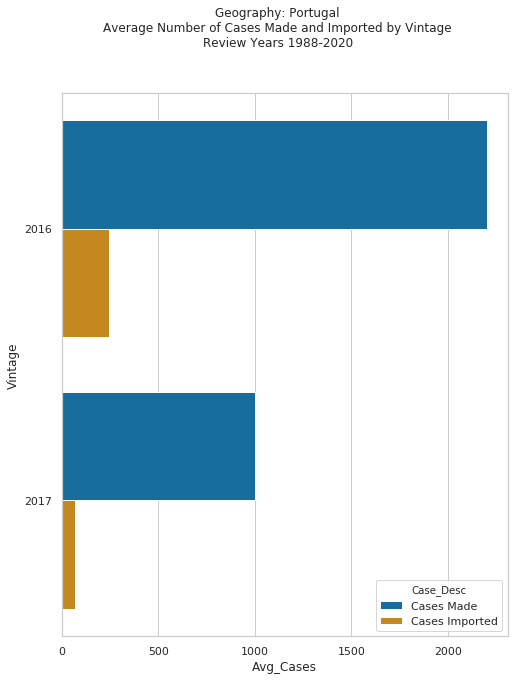

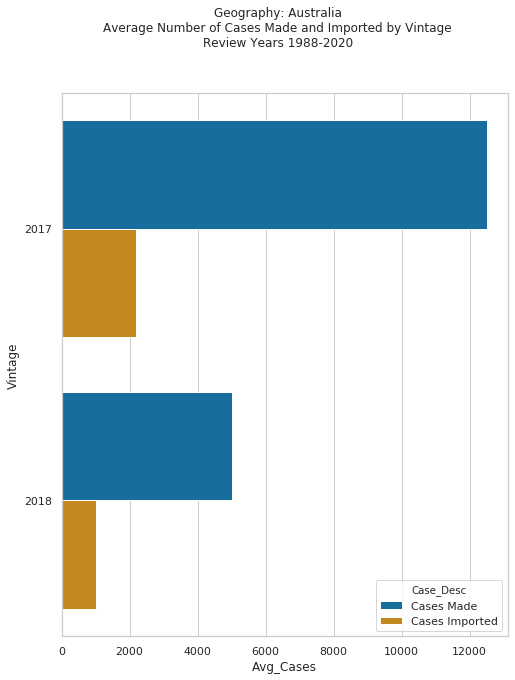

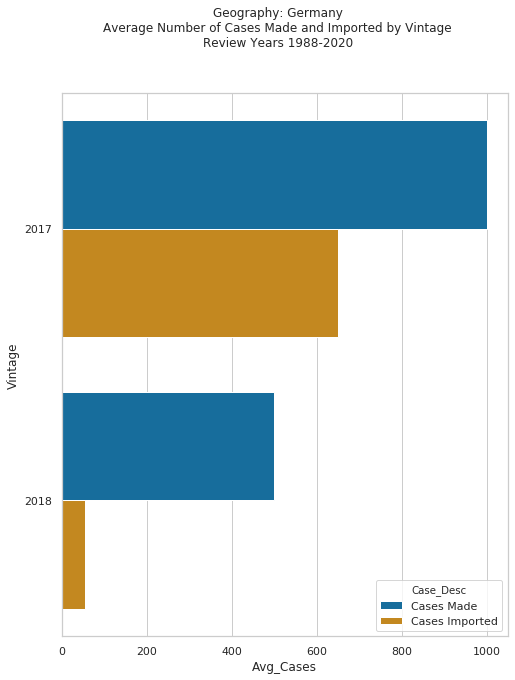

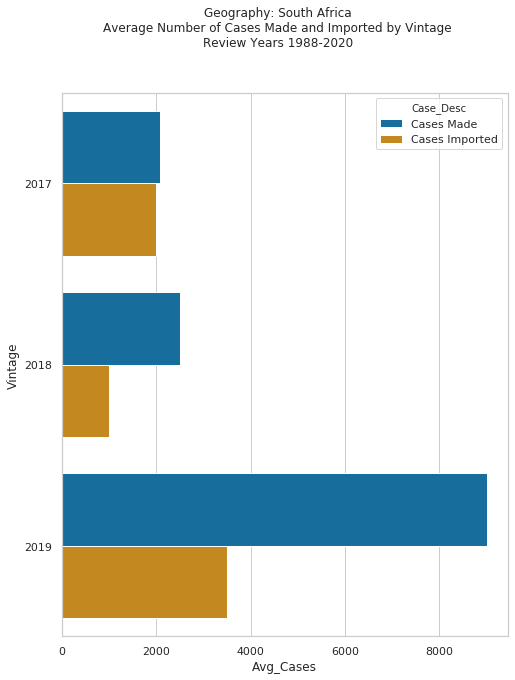

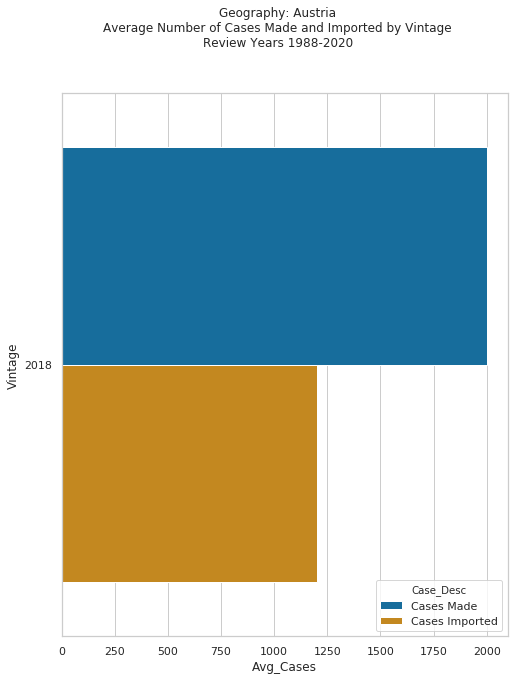

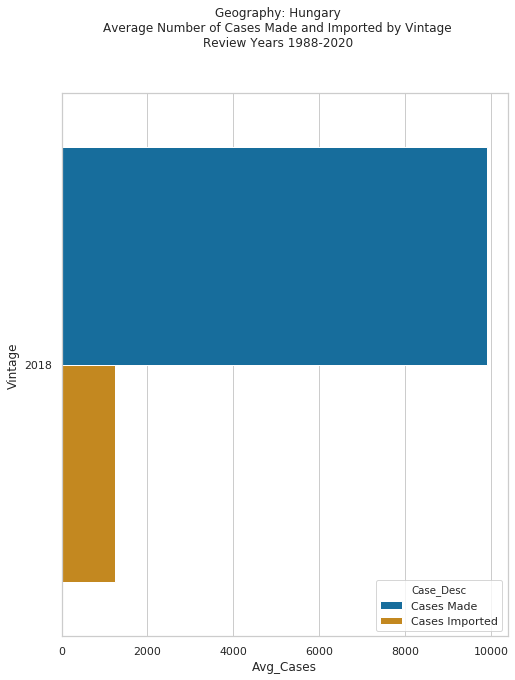

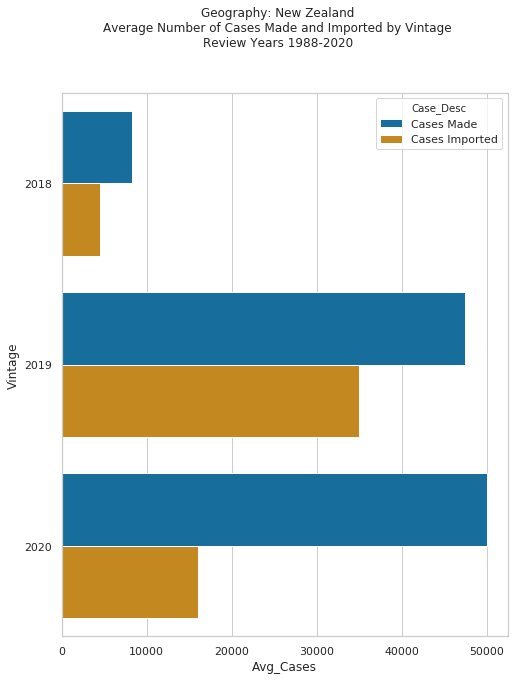

In [868]:
addresses = df_Cases_A.Address.unique()
addresses

for address in addresses:
    gpbar('address', address)